<a href="https://colab.research.google.com/github/matambotinashe/time-series-forecasting/blob/moving-averages-forecasting/2-Moving-Average-Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Moving Average Series Forcasting**
- In this notebook will demostrate moving average time series forecasting.

## **Libraries**
- In this notebook will use the numpy, tensorflow and matplotlib.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## **Time Series**
- We use all the function previously created in the Intro to Time series notebook to generate a seasonal trend time series.

In [ ]:
def plot_series(time, series, format = '-', start = 0, end = None, label = None):
  plt.plot(time[start:end], series[start:end], format, label = label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

In [ ]:
def trend(time, slope = 0):
  return slope * time

In [ ]:
def seasonal_pattern(season_time):
  """Just an arbitray pattern"""
  return np.where(season_time < 0.4, np.cos(season_time *2*np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

In [ ]:
def white_noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

## Time Series
- Now will generate the time series as done before.

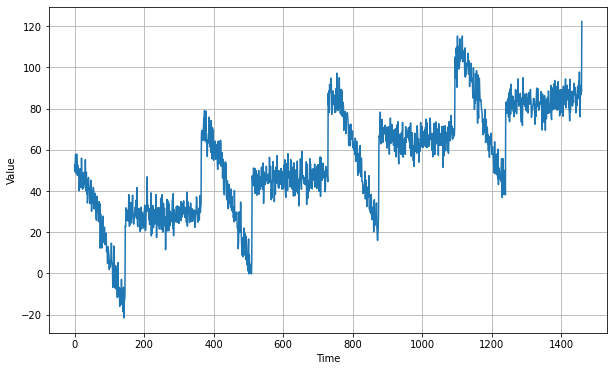

In [ ]:
time = np.arange(4 * 365 + 1)
baseline = 10

amplitude = 40
slope = 0.05

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

#white  noise
noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

series += noise

FIGSIZE = (10,6)
plt.figure(figsize = FIGSIZE)
plot_series(time, series)
plt.show()

## **Forecasting**
- Inorder to forecast, we will split our data into train and test data.
- Will use the first 1000 days as the train data and the rest as the test data.
- Will be using a fixed training window.


In [ ]:
train_cut_off = 1000

train_time = time[:train_cut_off]
test_time = time[train_cut_off:]

train_series = series[:train_cut_off]
test_series = series[train_cut_off:]

### Naive Forecasting.
- For Naive forecasting will be using the value at time "t-1" as the forecast value for value expected at time "t".

In [ ]:
naive_forecast = series[train_cut_off-1:-1]

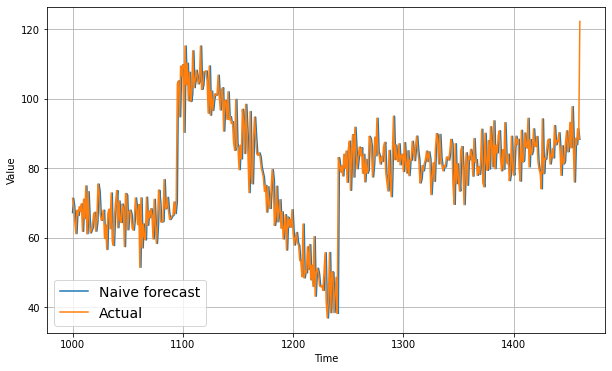

In [ ]:
plt.figure(figsize = FIGSIZE)
plot_series(test_time, naive_forecast, label = 'Naive forecast')
plot_series(test_time, test_series, label = 'Actual')

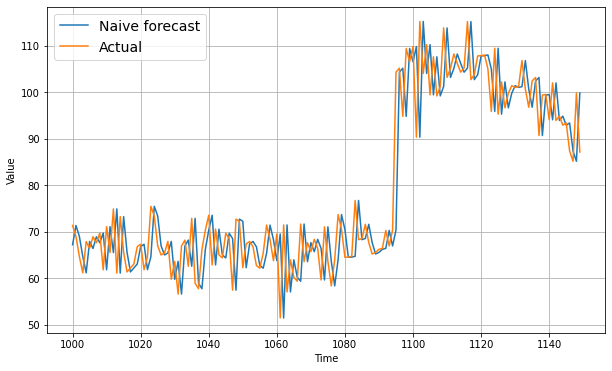

In [ ]:
plt.figure(figsize = FIGSIZE)
plot_series(test_time, naive_forecast, label = 'Naive forecast', end = 150)
plot_series(test_time, test_series, label = 'Actual', end = 150)

## Performance
- For our naive forecasting will use the meant absolute error (MAE) to measure how our forecasting is performing.
- This will form the betchmark to measure future forecasting against.

In [ ]:
absolute_error = np.abs(naive_forecast - test_series)
mean_absolute_error = absolute_error.mean()
mean_absolute_error

5.9379085153216735

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(test_series, naive_forecast).numpy()
mae

5.9379085153216735

## **Moving averages**
- Now that we have got our benchmark to measure against we will forecast using moving averages.


In [ ]:
def moving_average_forecast(series, window_size):
  """ Function computes the moving average of series given the size of the window to be used."""

  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:- window_size]
  
  return mov[window_size-1:-1]/window_size


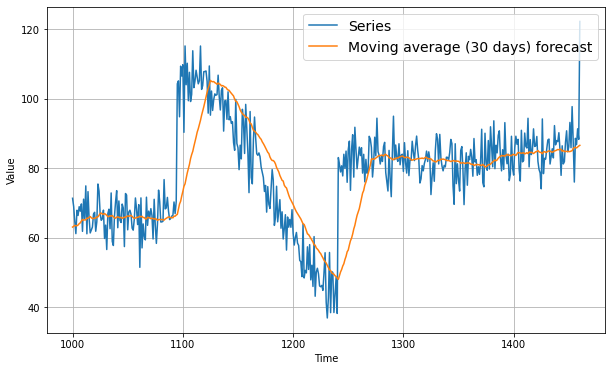

In [ ]:
WINDOW_SIZE = 30
moving_avg = moving_average_forecast(series, WINDOW_SIZE)[train_cut_off - WINDOW_SIZE:]

plt.figure(figsize = FIGSIZE)
plot_series(test_time, test_series, label = 'Series')
plot_series(test_time, moving_avg, label = 'Moving average ({} days) forecast'.format(WINDOW_SIZE))

In [ ]:
mae_mavg = tf.keras.metrics.mean_absolute_error(test_series, moving_avg).numpy()
mae_mavg

7.142418570620786

__Comments__
- Due to the forecasting not being able to articipate the change yet to come and have delayed response, the forecasting is worst than the benchmark.
### **Removing Trend and Seasonality**
- To improve the performace will have to remove the trend and the seasonality by differencing.
- As we know that our series has an annual seasonality will different over a year.

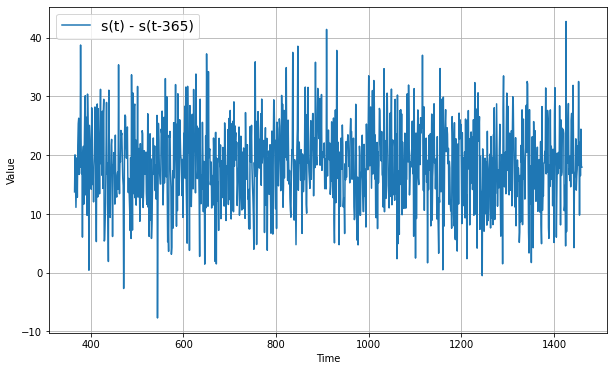

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize = FIGSIZE)
plot_series(diff_time, diff_series, label = 's(t) - s(t-365)')
plt.show()

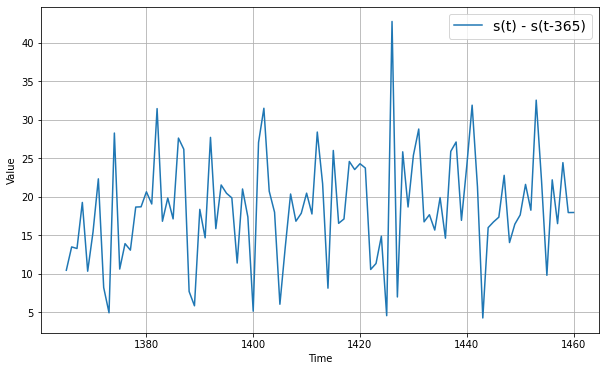

In [ ]:
plt.figure(figsize = FIGSIZE)
plot_series(diff_time, diff_series, label = 's(t) - s(t-365)', start = train_cut_off)
plt.show()

__Comments__
- With the differencing eliminating the seasonality and the trend, now will apply the moving avearage forecasting.

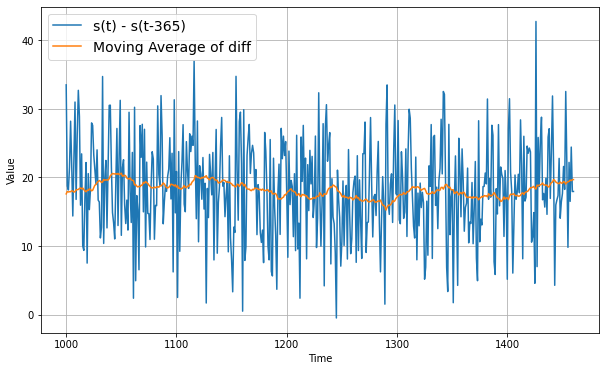

In [ ]:
WINDOW_SIZE = 50
diff_moving_avg = moving_average_forecast(diff_series, WINDOW_SIZE)[train_cut_off - 365 - WINDOW_SIZE: ]

plt.figure(figsize = FIGSIZE)
plot_series(test_time, diff_series[train_cut_off - 365:], label = 's(t) - s(t-365)')
plot_series(test_time, diff_moving_avg, label = 'Moving Average of diff')

__Comments__
- Now do use the moving average of the difference will now add back the seasonality and trend.
- This is done by adding data as at t-365

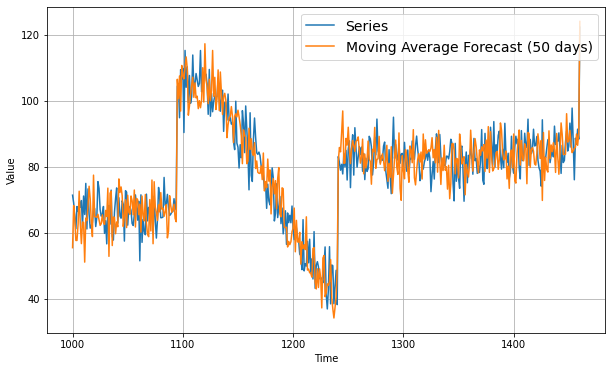

In [ ]:
diff_moving_avg_plus_past = series[train_cut_off - 365: - 365] + diff_moving_avg

plt.figure(figsize = FIGSIZE)
plot_series(test_time, test_series, label = 'Series')
plot_series(test_time, diff_moving_avg_plus_past, label = 'Moving Average Forecast ({} days)'.format(WINDOW_SIZE))

In [ ]:
mae_moving_avg_tren = tf.keras.metrics.mean_absolute_error(test_series, diff_moving_avg_plus_past).numpy()
mae_moving_avg_tren

5.8393105629958955

__Comments__
- The approach performed a little better than the benchmark from naive forecasting.
- Now will try to smoothen the noise on the forecastion by applying the moving average on the past data we added to moving average of the difference.

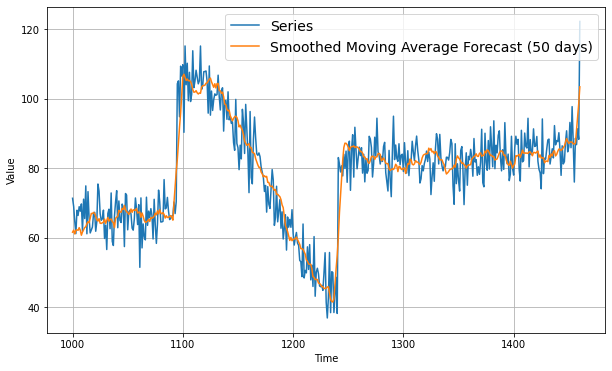

In [ ]:
past_window_size = 5

m_avg_plus_smooth_past = moving_average_forecast(series[train_cut_off - 365 - past_window_size: - 365 + past_window_size -1], past_window_size*2-1) + diff_moving_avg

plt.figure(figsize = FIGSIZE)
plot_series(test_time, test_series, label = 'Series')
plot_series(test_time, m_avg_plus_smooth_past, label = 'Smoothed Moving Average Forecast ({} days)'.format(WINDOW_SIZE))

In [ ]:
mae_moving_avg_smooth_tren = tf.keras.metrics.mean_absolute_error(test_series, m_avg_plus_smooth_past).numpy()
mae_moving_avg_smooth_tren

4.549848511811744